<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 25.4MB/s 


Grab the data

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-07-12 04:05:57--  https://docs.google.com/uc?export=download&confirm=yNnu&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 142.250.188.206, 2607:f8b0:4004:836::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-c4-docs.googleusercontent.com/docs/securesc/j23tdl6b2vdc80t8ej0uehitd85qc5bj/6gie58iv1dde85h8d7nekoncm8t8di04/1626062700000/06203730782251856755/05696315275309419709Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-07-12 04:05:57--  https://doc-0g-c4-docs.googleusercontent.com/docs/securesc/j23tdl6b2vdc80t8ej0uehitd85qc5bj/6gie58iv1dde85h8d7nekoncm8t8di04/1626062700000/06203730782251856755/05696315275309419709Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-0g-c4-docs.googleusercontent.com (doc-0g-c4-docs.googleusercontent.com)... 172.217.15.65, 2607:f8b0:4004:810::2001
Connecting to doc-

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [4]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temp'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temp"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temp"])

In [5]:
#ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
#                          "silicate", "NO", "PO"]
ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
                          "silicate", "nitrate", "phosphate", "oxygen"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES+["latitude", "longitude"]

#feature_weights = {"conservative_temp": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}

#Weight all features equally for now...
feature_weights = {"conservative_temp": 1.0,
                   "absolute_salinity": 1.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0,
                   "nitrate": 1.0,
                   "phosphate": 1.0,
                   "oxygen": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                          0.000000
longitude                         0.000000
year                              0.000000
depth                             0.001663
pressure                          0.001663
temperature                       0.004228
salinity                          0.011072
oxygen                            0.096587
silicate                          0.198236
nitrate                           0.161553
phosphate                         0.175817
sigma0                            0.013564
NO                                0.183883
PO                                0.196824
potential_temp                    0.013672
absolute_salinity                 0.011072
conservative_temp                 0.013407
sigma2                            0.013407
sigma4                            0.013407
standardized_conservative_temp    0.013407
standardized_absolute_salinity    0.011072
standardized_silicate             0.1

On water mass AABW
Ranges: {'lat_min': -66.5, 'lat_max': -61.5, 'lon_min': -160.0, 'lon_max': 150.0, 'sig4_min': 46.04, 'sig4_max': 200}


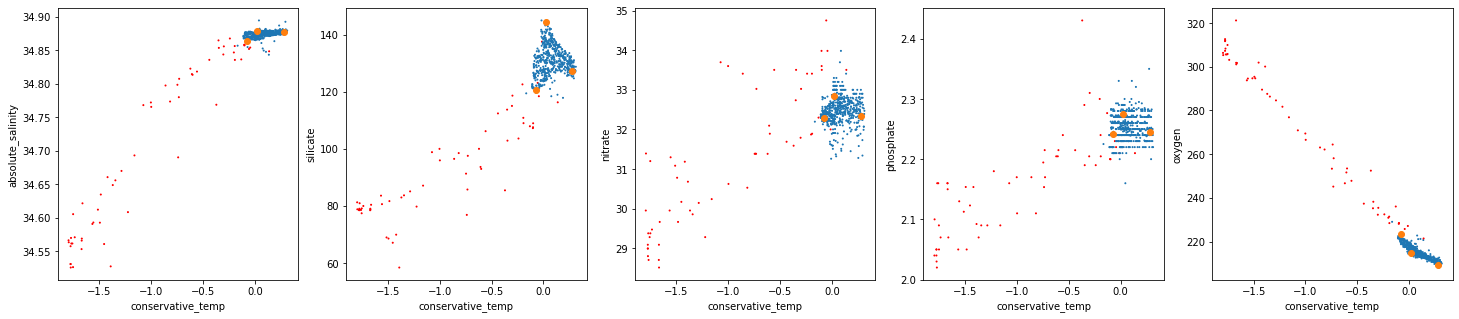

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,0.278486,34.876944,127.114519,32.333800,2.245143,209.385084,-63.811977,-117.253019,AABW_0
1,-0.076352,34.864137,120.537177,32.277449,2.241711,223.415620,-63.720136,-5.148866,AABW_1
2,0.020547,34.878673,144.358022,32.847029,2.274691,214.764124,-64.596445,-102.997708,AABW_2


On water mass AAIW
Ranges: {'lat_min': -55.0, 'lat_max': -43.0, 'lon_min': -90, 'lon_max': -80, 'sig0_min': 27.05, 'sig0_max': 27.15}


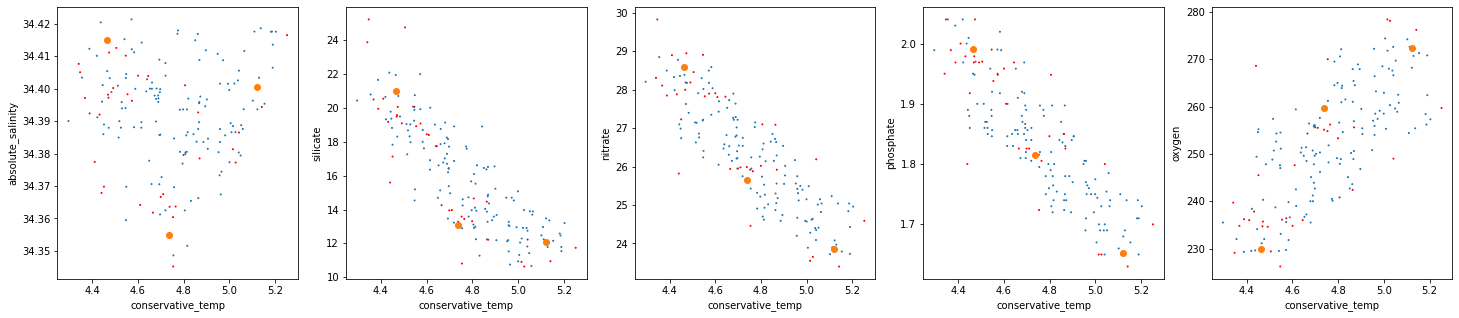

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,5.121599,34.400622,12.082309,23.846995,1.652242,272.435635,-50.116341,-87.759672,AAIW_0
1,4.464091,34.415098,21.019641,28.589619,1.990863,229.976964,-47.277058,-88.605459,AAIW_1
2,4.737412,34.354896,13.061728,25.653667,1.815674,259.651536,-53.616428,-89.000742,AAIW_2


On water mass ENPCW
Ranges: {'lat_min': 16, 'lat_max': 26, 'lon_min': -170, 'lon_max': -140, 'sig0_min': 25.0, 'sig0_max': 25.8}


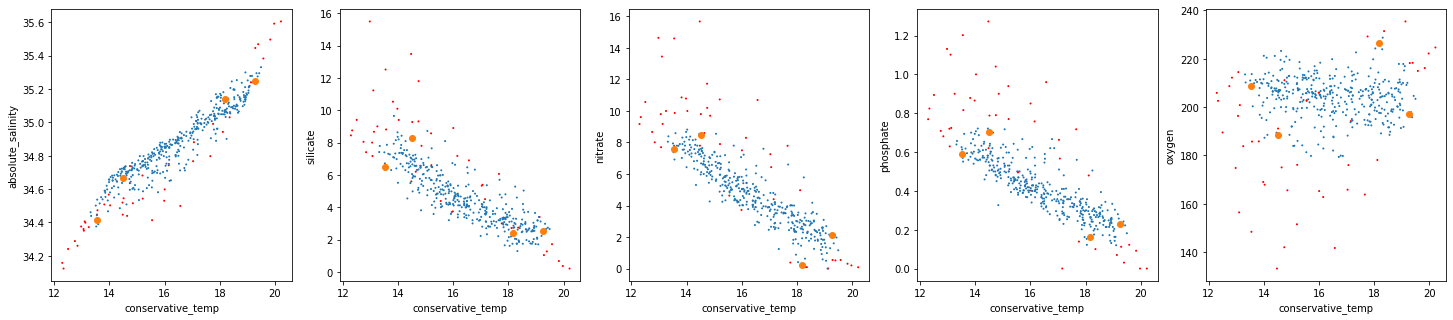

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,13.537308,34.413485,6.478788,7.617829,0.588651,208.566142,20.717383,-148.235134,ENPCW_0
1,18.173023,35.141795,2.419203,0.247636,0.164072,226.474429,24.798610,-160.170407,ENPCW_1
2,14.507411,34.667889,8.304639,8.503402,0.704675,188.567670,19.942220,-157.410956,ENPCW_2
3,19.264418,35.246527,2.533511,2.114221,0.228114,196.914390,20.719724,-155.988551,ENPCW_3


On water mass EqPW
Ranges: {'lat_min': -5, 'lat_max': 5, 'lon_min': -90.0, 'lon_max': -80.0, 'sig0_min': 26.0, 'sig0_max': 27.0}


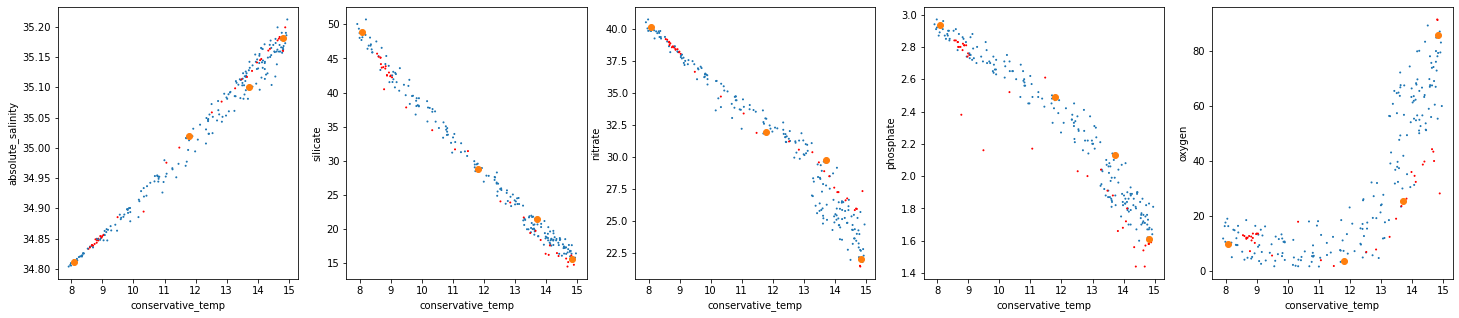

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,8.078438,34.811733,48.931562,40.154430,2.932889,9.974741,2.504964,-86.393534,EqPW_0
1,13.714531,35.100681,21.480742,29.768123,2.132431,25.273013,1.638498,-86.245151,EqPW_1
2,11.792358,35.019604,28.815019,31.942770,2.486790,3.617862,-3.902486,-85.873049,EqPW_2
3,14.823696,35.182182,15.664143,22.027785,1.610936,85.897037,-2.241109,-85.830360,EqPW_3


On water mass LCDW
Ranges: {'lat_min': -66.5, 'lat_max': -61.5, 'lon_min': -160.0, 'lon_max': 150.0, 'sig0_min': 27.79, 'sig0_max': 27.83}


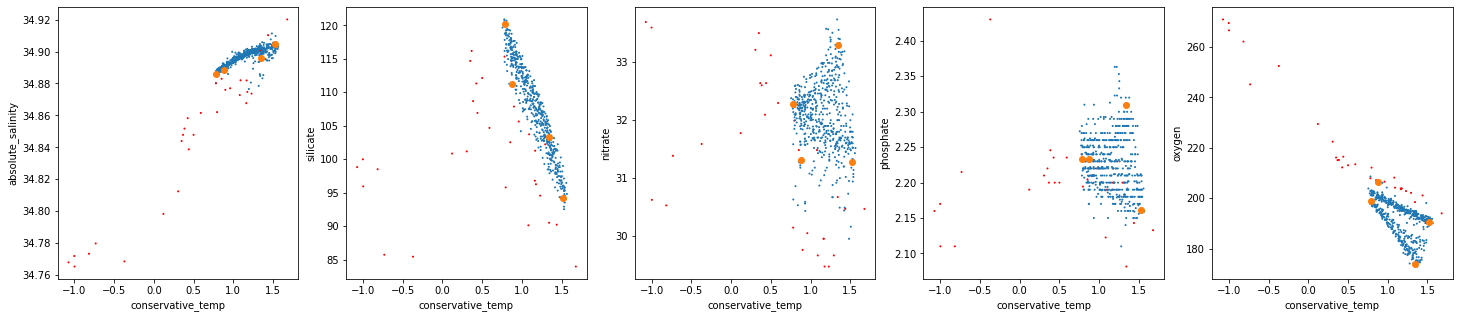

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,0.877707,34.888476,111.316178,31.306213,2.233111,206.440223,-64.083844,132.416904,LCDW_0
1,1.343654,34.896195,103.270705,33.293642,2.308956,173.838240,-62.626699,-149.983921,LCDW_1
2,0.785235,34.886067,120.249030,32.271437,2.233252,198.781252,-64.348716,-143.789783,LCDW_2
3,1.523930,34.904798,94.228354,31.280530,2.160794,190.718843,-65.547250,-118.588176,LCDW_3


On water mass NPIW
Ranges: {'lat_min': 34.0, 'lat_max': 37.0, 'lon_min': 140.0, 'lon_max': 153.0, 'sig0_min': 26.6, 'sig0_max': 27.0, 'ox_min': 0, 'ox_max': 150.0}


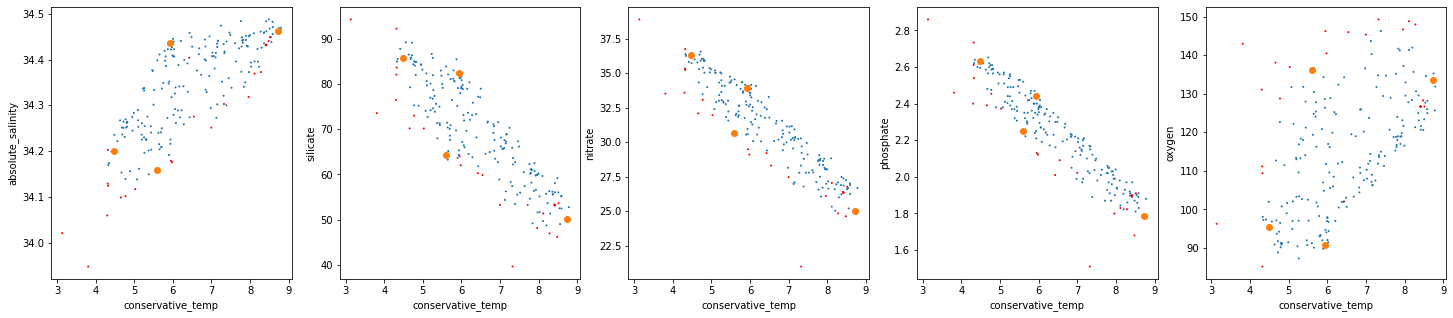

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,8.730580,34.461863,50.102425,25.025918,1.784620,133.466471,34.894543,142.285674,NPIW_0
1,4.477485,34.200292,85.849385,36.365761,2.635112,95.457325,36.940138,145.515120,NPIW_1
2,5.595667,34.158309,64.248162,30.687523,2.252409,136.217696,34.245923,149.347011,NPIW_2
3,5.930705,34.436713,82.492232,33.960866,2.441231,90.679822,34.917707,140.282447,NPIW_3


On water mass PDW1
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig0_min': 27.6, 'sig0_max': 200, 'sig2_min': 0, 'sig2_max': 36.96}


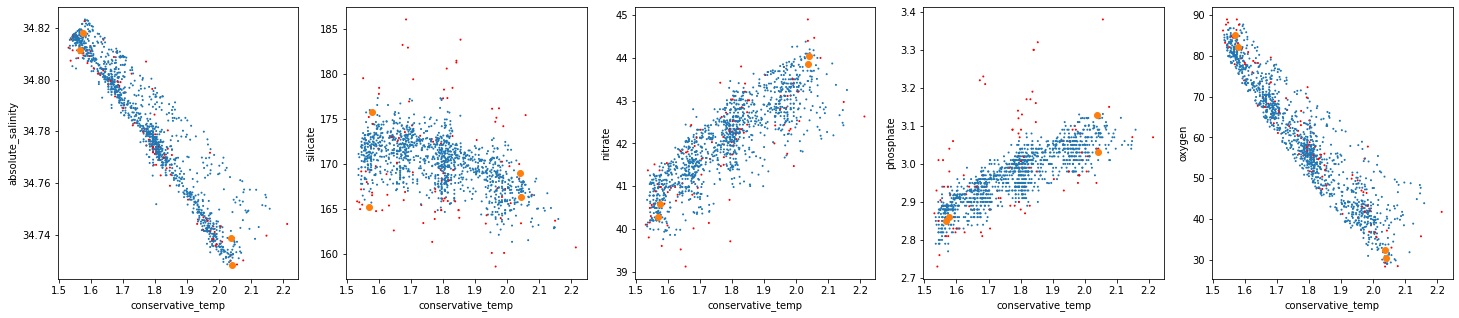

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.576290,34.817948,175.724725,40.589744,2.859529,82.235303,44.398820,-137.711290,PDW1_0
1,2.037877,34.738648,169.016014,43.861676,3.128245,32.522158,42.128412,-152.000070,PDW1_1
2,1.568219,34.811440,165.260000,40.270000,2.850000,85.140000,46.998000,-164.870000,PDW1_2
3,2.041334,34.728176,166.318236,44.048152,3.030915,30.418420,43.892094,-162.097096,PDW1_3


On water mass PDW2-3
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.88}


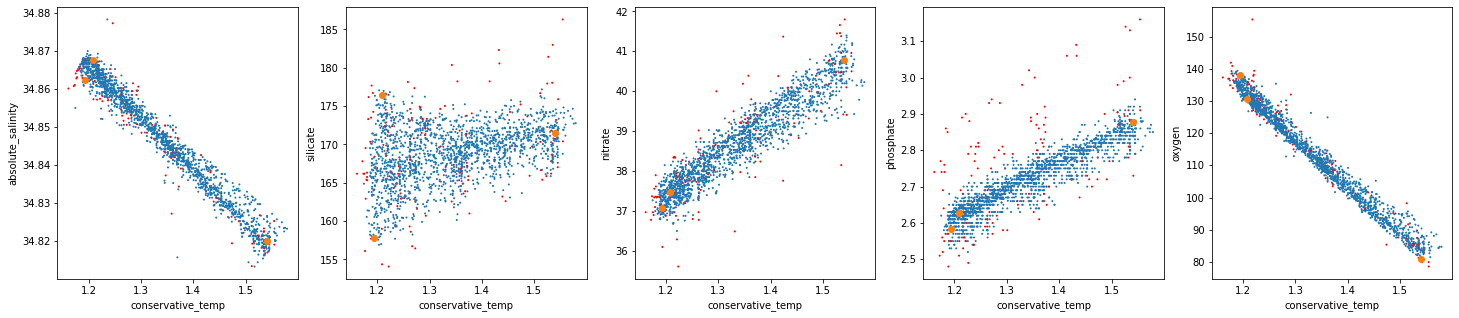

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.193496,34.862337,157.809583,37.073256,2.583704,138.050967,45.348967,-163.845620,PDW2-3_0
1,1.208390,34.867615,176.499907,37.479532,2.628291,130.483789,44.183292,-136.907595,PDW2-3_1
2,1.540206,34.820039,171.556521,40.790705,2.877636,81.047392,46.525043,-154.389896,PDW2-3_2


On water mass PSIW
Ranges: {'lat_min': 40, 'lat_max': 47, 'lon_min': -160, 'lon_max': 160, 'sig0_min': 26.899, 'sig0_max': 27.195}


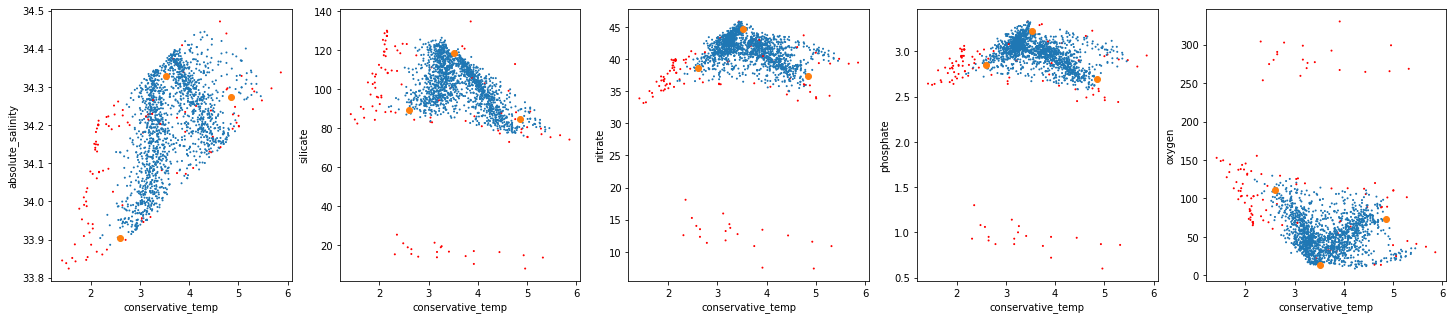

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,2.600960,33.902794,89.402534,38.608475,2.847917,110.449330,42.222156,148.252140,PSIW_0
1,4.849233,34.272733,84.553194,37.436707,2.698761,73.491122,41.787730,76.147091,PSIW_1
2,3.523430,34.328007,118.805986,44.737576,3.219975,13.663486,46.451488,107.938338,PSIW_2


On water mass PSUW
Ranges: {'lat_min': 50, 'lat_max': 58, 'lon_min': -155, 'lon_max': -140, 'sig0_min': 25.0, 'sig0_max': 25.6}


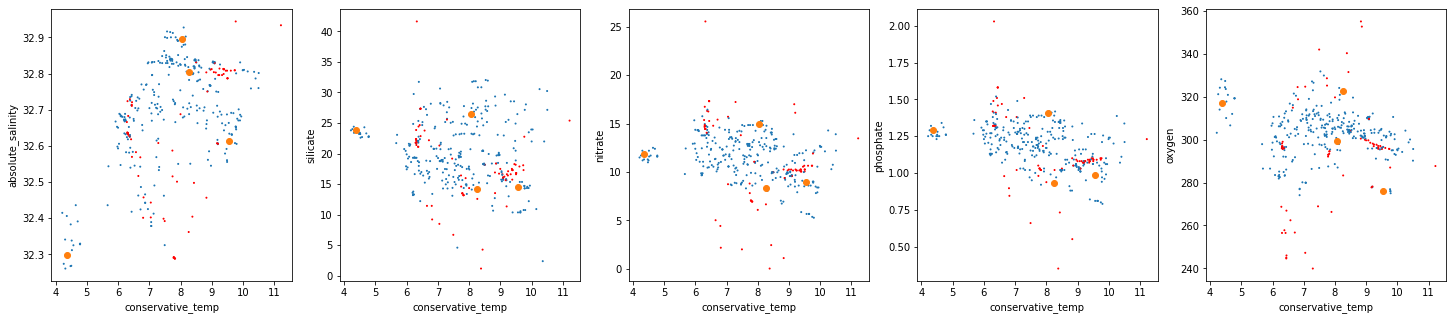

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,8.055261,32.895869,26.439098,15.007531,1.408770,299.262921,50.750184,-147.625513,PSUW_0
1,4.372494,32.298953,23.780287,11.884413,1.291265,316.963880,56.144179,-153.157347,PSUW_1
2,8.256633,32.805675,14.138737,8.317507,0.931829,322.694508,51.150099,-144.995242,PSUW_2
3,9.551026,32.613170,14.489312,8.990924,0.988415,276.190004,50.634333,-145.830290,PSUW_3


On water mass UCDW
Ranges: {'lat_min': -49.5, 'lat_max': -44.5, 'lon_min': -157.0, 'lon_max': -147.0, 'sig0_min': 27.35, 'sig0_max': 27.75}


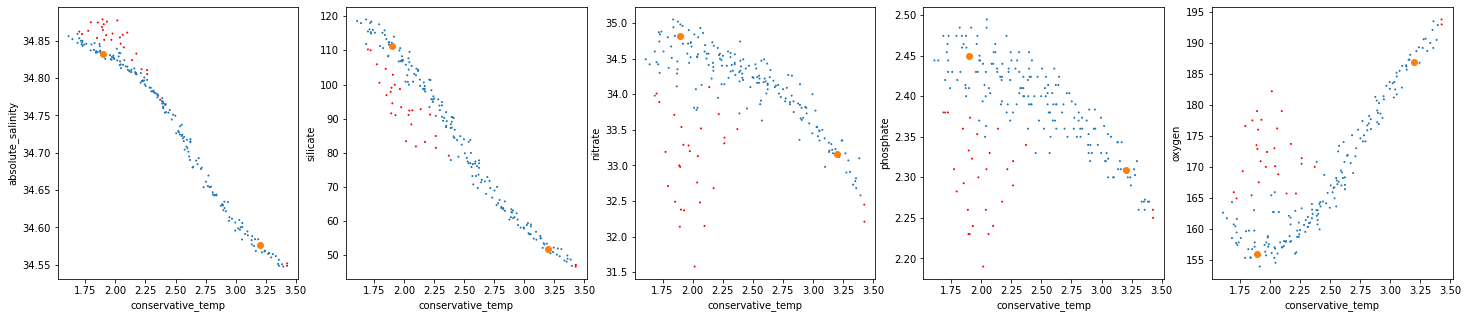

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.897235,34.832715,111.311382,34.810766,2.449827,155.895625,-44.977748,-150.0,UCDW_0
1,3.201435,34.576839,51.984665,33.164372,2.308831,186.945768,-46.143025,-150.0,UCDW_1


In [13]:
from py_pcha import PCHA
import scipy 
from scipy import spatial
from IPython.display import display, HTML


def flag_outliers(features, n_neighbors=20, zscore_threshold=1):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors+1], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    #plt.hist(zscore_avgdisttonn, bins=100)
    #plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    np.random.seed(1234) #fix seed for reproducibility of results
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(25,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

#num_archetypes is not really a filter condition but this is the easiest
# place to store that feature
filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15,
             "num_archetypes":3},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0,
             "sig0_min":26.6, "sig0_max":27.0, #different from 26.5-27.4 in spreadsheet
             "ox_min":0, "ox_max":150.0,
             "num_archetypes":4},
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             "num_archetypes":2},
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-160.0, "lon_max":150.0,
             "sig0_min":27.79, "sig0_max":27.83,
             "num_archetypes":4},
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-160.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             "num_archetypes":3},
    "PDW1": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig2_min":0, "sig2_max":36.96,
             'num_archetypes':4},
    "PDW2-3": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.88,
             "num_archetypes":3},
    "EqPW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.0, "sig0_max": 27.0,
             "num_archetypes":4},
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.0, "sig0_max": 25.6,
             "num_archetypes":4},
    "ENPCW": {"lat_min":16, "lat_max":26, 
             "lon_min":-170, "lon_max":-140,
             "sig0_min": 25.0, "sig0_max": 25.8,
             "num_archetypes":4},
    "PSIW": {"lat_min":40, "lat_max":47, 
             "lon_min":-160, "lon_max":160,
             "sig0_min": 26.899, "sig0_max": 27.195,
             "num_archetypes":3}
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max,
                sig0_min=0, sig0_max=np.inf, 
                sig2_min=0, sig2_max=np.inf,
                sig4_min=0, sig4_max=np.inf,
                ox_min=0, ox_max=np.inf):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max) &
            (df["sigma2"] >= sig2_min) &
            (df["sigma2"] <= sig2_max) &
            (df["sigma4"] >= sig4_min) &
            (df["sigma4"] <= sig4_max) &
            (df["oxygen"] >= ox_min) &
            (df["oxygen"] <= ox_max) 
            ]

watermass_to_archetypes = {}

for watermass in sorted(filter_conditions.keys()):
  print("On water mass", watermass)
  num_archetypes = filter_conditions[watermass]['num_archetypes']
  del filter_conditions[watermass]['num_archetypes']
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(
      df=watermass_rows,
      num_endmembers=num_archetypes)
  watermass_archetypes["watermass_name"] = [watermass+"_"+str(i)
                                            for i in range(num_archetypes)]
  watermass_to_archetypes[watermass] = watermass_archetypes
  display(watermass_archetypes)

full_watermass_df = pandas.concat([watermass_to_archetypes[watermass]
                          for watermass in sorted(watermass_to_archetypes.keys())])

In [15]:
full_watermass_df.to_csv("GP15_intermediateanddeep_endmemberswithsubtypes_July11.csv",
                         columns=["watermass_name"]+ALL_FEATURES_TO_AVERAGE,
                         index=False)